## Functional control of oscillators - brain application

In [79]:
import numpy as np
import pandas as pd
import math as m
import random as r
import cvxpy as cp
from scipy.integrate import odeint
import seaborn as sns
import KuramotoFunctionBank as KFB
import GPMAlgorithm as GPM
import importlib
import matplotlib.pyplot as plt
import csv
import cmath
from scipy.signal import butter, lfilter, hilbert
importlib.reload(KFB)
importlib.reload(GPM)

<module 'GPMAlgorithm' from '/home/nartallokalu/Desktop/kuramotocontrol/GPMAlgorithm.py'>

In [72]:
N = 66
Subj18Run2 = open('Subject18Run2.txt', 'r')
permutation = open('permutation.txt','r')
reader = csv.reader(Subj18Run2)
reader2 = csv.reader(permutation)
DataAsList = [row for row in reader]
permutation = [x-1 for x in list(map(int, [row.split(',') for row in permutation][0]))]
DataAsArray =[]
for data in DataAsList:
    DataAsArray.append(data[0].split(' '))
for i in range(0,len(DataAsArray)):
    while '' in DataAsArray[i]:
        DataAsArray[i].remove('')
    for j in range(0,len(DataAsArray[i])):
        DataAsArray[i][j]=float(DataAsArray[i][j])
DataAsArray=np.array(DataAsArray)
#Phase-locked region is the same as the one obtained by Basset et al.
#Permute according to parcellation
DataAsArray=DataAsArray[:,permutation]


In [85]:
FilteredSignals =KFB.butter_bandpass_filter(DataAsArray,0.04,0.06,0.5,10)
analytic_signal = hilbert(FilteredSignals,axis=0)
Hilbert = np.zeros((300,N))
for i in range(0,N):
    for t in range(0,300):
        Hilbert[t,i]=m.atan2(analytic_signal[t,i].real,analytic_signal[t,i].imag)
BOLDPhases = Hilbert[248:269,:]

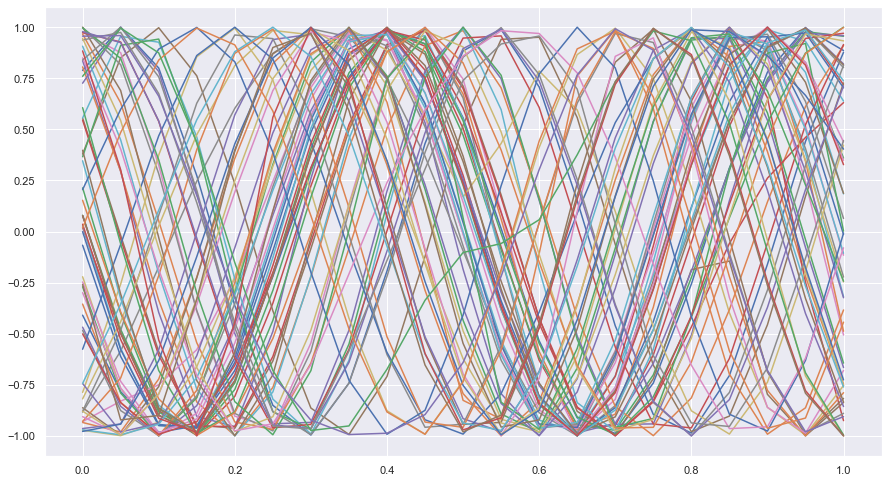

In [86]:
t = np.linspace(0,1,21)
for i in range(0,N):
    sns.lineplot(t,np.sin(BOLDPhases[:,i]))
BOLDPhases_no_mod = KFB.RemoveBounds(BOLDPhases)

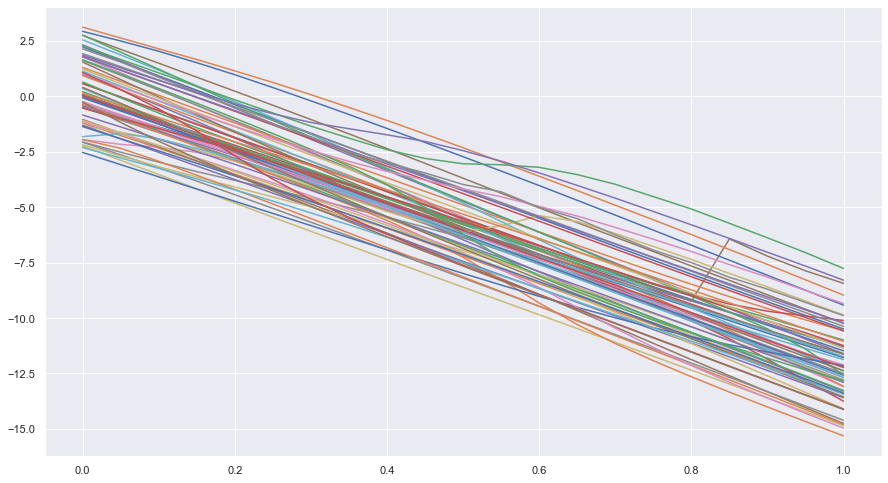

In [87]:
for i in range(0,N):
    sns.lineplot(t,BOLDPhases_no_mod[:,i])

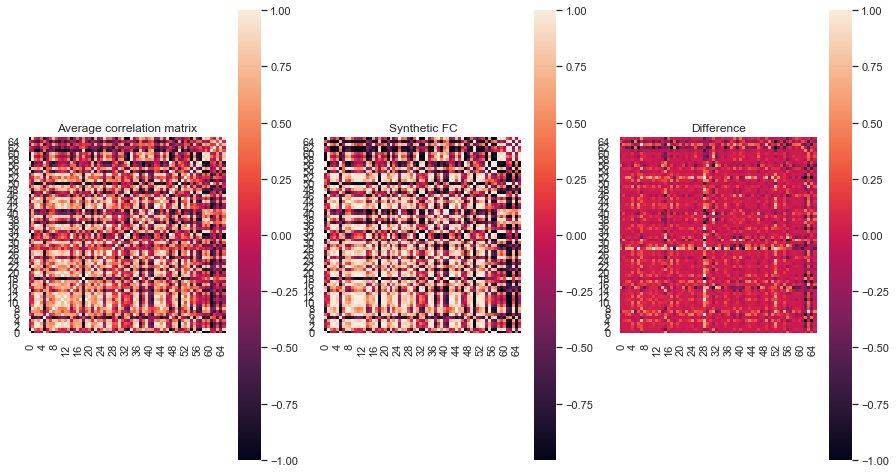

In [88]:
sns.set(rc={'figure.figsize':(15,8.27)})

Cos_Phase_Differences = np.zeros((N,N,20))
Phase_Differences = np.zeros((N,N,20))
for i in range(0,20):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(BOLDPhases_no_mod[i][k]-BOLDPhases_no_mod[i][j])
            Phase_Differences[j][k][i] = BOLDPhases_no_mod[i][k]-BOLDPhases_no_mod[i][j]
Average_Cos_Phase_Difference = np.mean(Cos_Phase_Differences,axis=2)
Average_Phase_Difference = np.mean(Phase_Differences,axis=2)
C = KFB.CalculateCFromMeanPhaseDiff(Average_Phase_Difference)
EstimatedPhases = GPM.GPMAlgorithm(C)
x_min_brain = KFB.CalculateXMinFromPhases(EstimatedPhases)
SyntheticFC = KFB.CalculateCorrelationMatrixFromPhases(EstimatedPhases)

fig, (ax1, ax2,ax3) = plt.subplots(1,3)
ax1= sns.heatmap(Average_Cos_Phase_Difference.T,ax=ax1,square=True,vmin=-1,vmax=1)
ax1.invert_yaxis()
ax2= sns.heatmap(SyntheticFC.T,ax=ax2,square=True)
ax2.invert_yaxis()
ax3= sns.heatmap(SyntheticFC.T-Average_Cos_Phase_Difference.T,ax=ax3,square=True,vmin=-1,vmax=1)
ax3.invert_yaxis()
ax1.title.set_text('Average correlation matrix')
ax2.title.set_text('Synthetic FC')
ax3.title.set_text('Difference')
plt.show()



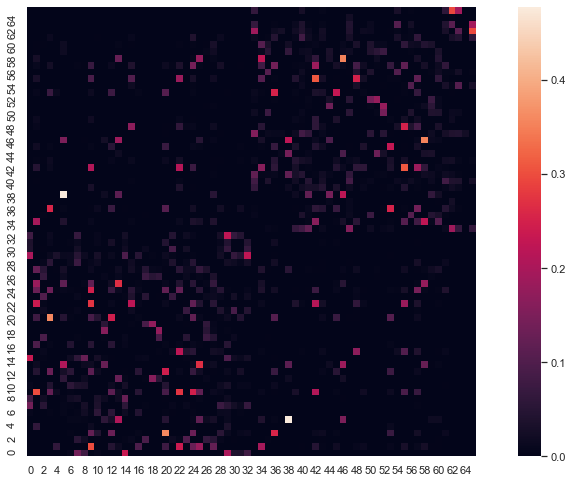

In [89]:
SC_DF = pd.read_csv('StructuralConnectivity.csv',header=None)
SCMatrix = np.array(SC_DF)
sns
#Remove Diagonals
SCMatrix = SCMatrix - np.diagflat(np.diag(SCMatrix))
SCMatrix = (SCMatrix+SCMatrix.T)/2
ax=sns.heatmap(SCMatrix.T,square=True)
ax.invert_yaxis()
#Calculate quantities from inital parameters 
edges = KFB.CalculateEdgeSet(SCMatrix)
x_desired = KFB.CalculatePhaseDifferencesFromMin(x_min_brain,edges)
D = KFB.CalculateSinMatrix(edges,x_desired)
B = KFB.CalculateIncidenceMatrix(edges,N)
B_D = np.matmul(B,D)
delta1 = KFB.CalculateDeltaFromAdj(SCMatrix,edges)

w=B_D@delta1


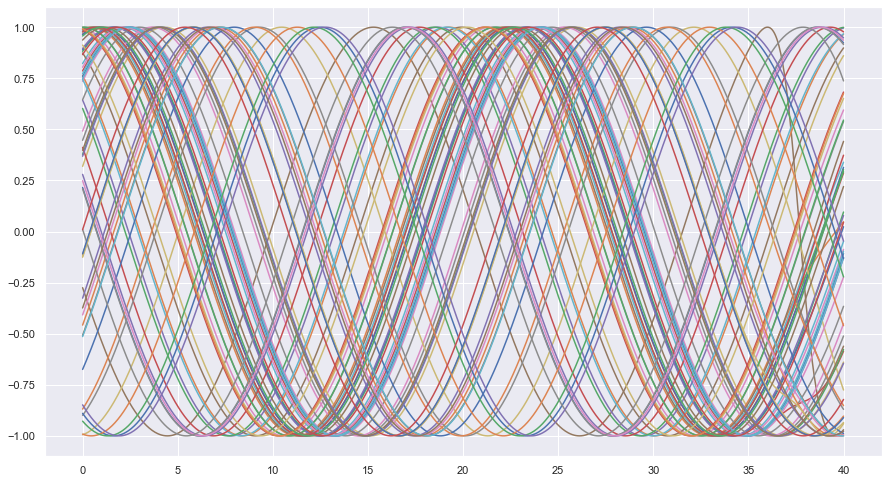

In [91]:
#Solving the model with these params
theta_0 = EstimatedPhases
T=40
num_points = 800

sol,t = KFB.SolveKuramotoModel(theta_0,T,N,w+0.29,SCMatrix,num_points)

#Plot oscillator trajcetories
for i in range(0,N):
    ax = sns.lineplot(x=t,y=np.sin(sol[:,i]))

In [92]:
rho = np.zeros((N,N))
for i in range(0,N):
    for j in range(i+1,N):
        rho[i,j]=np.mean(np.cos(sol[:,j]-sol[:,i]))
rho = rho + rho.T + np.identity(N)

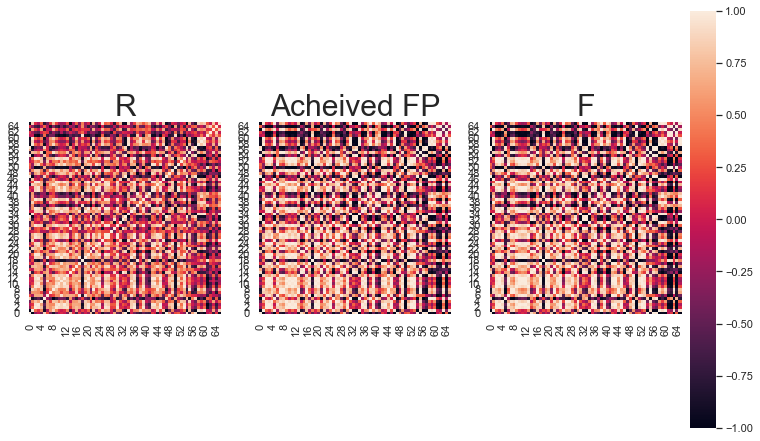

In [93]:
#Plot the acheived functional pattern to compare to the desired functional pattern
x_acheived = KFB.CalculatePhaseDiffs(sol[num_points-1,:])
Rho_acheived = KFB.CalculateCorrelationMatrix(x_acheived)
Rho_desired = KFB.CalculateCorrelationMatrix(x_min_brain)

sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.title.set_text('R')
ax1.title.set_size(30)
ax2.title.set_text('Acheived FP')
ax2.title.set_size(30)
ax3.title.set_text('F')
ax3.title.set_size(30)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
sns.heatmap(Average_Cos_Phase_Difference.T, ax=ax1,square=True,cbar_ax=cbar_ax,vmin=-1,vmax=1)
sns.heatmap(Rho_acheived.T, ax=ax2,square = True,cbar_ax=cbar_ax,vmin=-1,vmax=1)
sns.heatmap(SyntheticFC.T, ax=ax3,square=True,cbar_ax=cbar_ax,vmin=-1,vmax=1)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
plt.show()